# Springboard take home assignment: <br>Relax Inc Data Science challenge 

## John Burt

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

The data is available as two attached CSV files:


- takehome_user_engagement.csv: A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years.


- takehome_users.csv: A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

## My approach:

- Load the data.
- Transform feature columns to numeric (category -> 1 hot, etc).
- Generate the engaged label column
- Train an XGBoost classifier to predict adoption.
- Cross-validate evaluate model.
- Display feature importances.
- Analyze results

In [104]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np


### Load and look at the data

### Engagement table:

In [56]:
eng = pd.read_csv('takehome_user_engagement.csv') 

print(eng.shape)
eng.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Users table:

In [57]:
usr = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")

print(usr.shape)
usr.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### Data prep and feature engineering

In [58]:
# convert time strings to datetime
eng['time'] = pd.to_datetime(eng['time_stamp'])
usr['ctime'] = pd.to_datetime(usr['creation_time'])

# create feature df
# I'll add to this features I've created from the user data
features = usr[ ['object_id',
                 'opted_in_to_mailing_list', 
                 'enabled_for_marketing_drip'] ]
print('features shape:',features.shape)

# parse email to get domain, then one-hot and add to features
domains = [str.split(s.split('@')[1],'.')[0] for s in usr['email']]
features = pd.concat([features, pd.get_dummies(domains, prefix='ed')], axis=1)
print('features shape:',features.shape)

# one-hot creation source
features = pd.concat([features, 
                      pd.get_dummies(usr['creation_source'], prefix='cs')], axis=1)
print('features shape:',features.shape)

# one-hot org id
features = pd.concat([features, 
                      pd.get_dummies(usr['org_id'], prefix='oi')], axis=1)
print('features shape:',features.shape)

# one-hot invited by
features = pd.concat([features, 
                      pd.get_dummies(usr['invited_by_user_id'], prefix='ui')], axis=1)
print('features shape:',features.shape)


features shape: (12000, 3)
features shape: (12000, 1187)
features shape: (12000, 1192)
features shape: (12000, 1609)
features shape: (12000, 4173)


### Function to test for adopted users
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period.

Note: This function takes as input a user's engagement dates converted into julian day  

In [88]:
def is_engaged(days):
    """Test if this user is engaged,
    Uses julian days"""
    for i in range(len(days)-2):
        if days[i+1]>days[i]:
            if ((days[i+1]-days[i] <= 7) &
               (days[i+2]-days[i] <= 7)):
                return 1
    return 0

# # run some tests:
# print(is_engaged([1,1,1,3,4,6,10])) # True
# print(is_engaged([1,10,30,31,31,31,35])) # True
# print(is_engaged([1,12,23,23,23,45,53])) # False
# print(is_engaged([1,2,34,35,50,57])) # False

### Create output label column "engaged"

- 1 = user engaged
- 0 = user not engaged

In [93]:
from datetime import datetime

# create day col
eng['day'] = eng['time'].apply(lambda dt : dt.timetuple().tm_yday + dt.year*365)

# make sure engagement data is sorted ascending by time
eng.sort_values(by='time', inplace=True)

# iterate through users, record engagement
usr['engaged'] = [is_engaged(eng['day'][eng['user_id']==id].values) 
                  for id in usr['object_id']]

print('#engaged =',usr['engaged'].sum(), ' out of',usr.shape[0])


#engaged = 1656  out of 12000


### Cross-validate the XGBoost model

In [100]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# create model instance
clf = XGBClassifier()

# get cross val score
scores = cross_val_score(clf, features, usr['engaged'], cv=5)

print('Cross-validate model:')
print('CV scores = ', ['%1.2f,'%(s) for s in scores])
print('mean score = %1.2f'%(np.mean(scores)))


Cross-validate model:
CV scores =  ['0.86,', '0.86,', '0.86,', '0.86,', '0.14,']
mean score = 0.72


### Re-train the model to all data

In [102]:
# re-fit to entire dataset
clf.fit(features, usr['engaged']);

### Print and plot the most important features

Feature ranking:
1. (0.055) cs_PERSONAL_PROJECTS
2. (0.028) oi_217
3. (0.025) oi_0
4. (0.025) oi_387
5. (0.025) oi_3
6. (0.022) oi_248
7. (0.022) ed_hotmail
8. (0.021) oi_62
9. (0.020) oi_82
10. (0.019) oi_1
11. (0.019) oi_392
12. (0.019) cs_GUEST_INVITE
13. (0.018) oi_270
14. (0.018) oi_415
15. (0.018) oi_13
16. (0.018) oi_282
17. (0.018) oi_117
18. (0.017) oi_235
19. (0.017) ed_yahoo
20. (0.016) oi_273


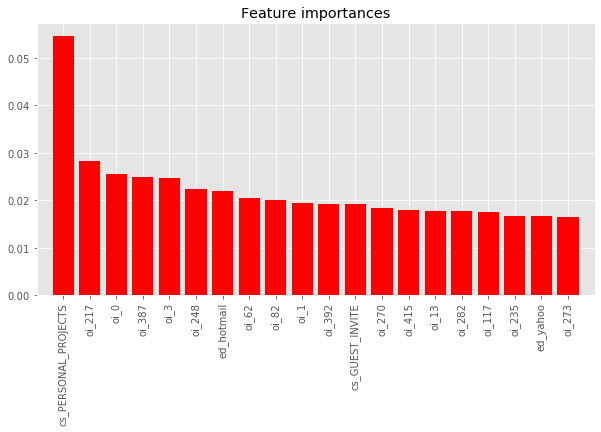

In [116]:
names = features.columns
numimportant = 20

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(numimportant):
    print("%d. (%1.3f) %s" % (
        f + 1, 
        importances[indices[f]],
        names[indices[f]]
         ))

# Plot the feature importances of the forest
plt.figure(figsize=[10,5])
plt.title("Feature importances")
plt.bar(range(numimportant), importances[indices[:numimportant]],
       color="r", align="center")
plt.xticks(range(numimportant), names[indices[:numimportant]], rotation=90)
plt.xlim([-1, numimportant]);


## Analysis

#### Goal: identify which factors predict future user adoption

- Looking at the top 20 important features, three categories were apparent:
    - Organization ID (16/20): most of the top features were from this category.
    - Creation source (2/20): PERSONAL_PROJECTS ("invited to join another user's
personal workspace") was the best predictor of engagement.
    - Email domain (2/20): engaged users most commonly used hotmail and yahoo domains.
    
    
